In [1]:
import xarray as xr
from pathlib import Path
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt

<Axes: >

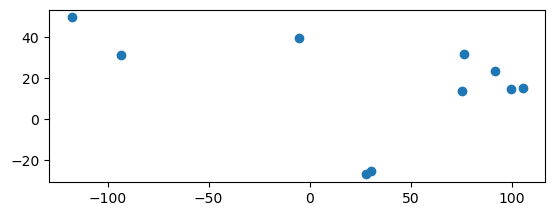

In [2]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
]

res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca'

}

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [3]:
# load
from pathlib import Path
import pandas as pd

hls_save_dir = Path('../data/hls')
hls_save_dir.mkdir(exist_ok=True)

dsses = []
reservoirs = []
available = []
platforms = []
times = []

for reservoir_id in selected_reservoirs:
    print(reservoir_id)

    fp = hls_save_dir / f'{reservoir_id}.zarr'
    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue

    ds = xr.open_zarr(fp)
    dsses.append(ds)

    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(ds.platform.values)
    times.extend(ds.time.values)

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})
df

0505
0810
0830
0502
0518
0349
0464
0214
1498
0936


,reservoir,available,platform,time
0,0505,True,Sentinel-2A,2019-01-02 04:41:48.360
1,0505,True,Sentinel-2B,2019-01-04 04:31:57.140
2,0505,True,Sentinel-2B,2019-01-07 04:41:52.710
3,0505,True,Sentinel-2A,2019-01-09 04:31:54.330
4,0505,True,Sentinel-2A,2019-01-12 04:41:49.830
...,...,...,...,...
1379,0936,True,Sentinel-2B,2024-03-11 11:20:17.836
1380,0936,True,Sentinel-2A,2024-03-13 11:10:24.819
1381,0936,True,Sentinel-2A,2024-03-16 11:20:21.715
1382,0936,True,Sentinel-2B,2024-03-21 11:20:21.671


Text(0.5, 1.0, 'HLS Data downloaded for selected reservoirs')

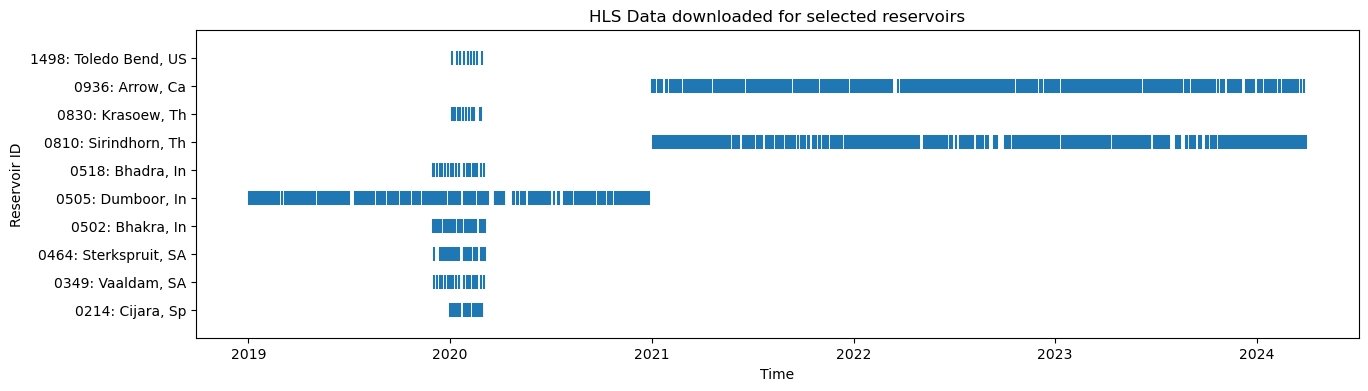

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
for i, reservoir_id in enumerate(df.groupby('reservoir').groups):
    data = df.loc[df['reservoir'] == reservoir_id]['time']
    name = res_names[reservoir_id]
    ax.eventplot(data, orientation='horizontal', linelengths=0.5, lineoffsets=i)
    yticks.append(i)
    ytick_labels.append(f"{reservoir_id}: {name}")

ax.set_yticks(ticks=yticks, labels=ytick_labels)
ax.set_ylabel('Reservoir ID')
ax.set_xlabel('Time')
ax.set_title('HLS Data downloaded for selected reservoirs')

/tmp/ipykernel_621416/4261826267.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res_poly_buffered['geometry'] = res_poly.buffer(buffer).to_crs(ds.rio.crs.to_string())


<Axes: xlabel='time', ylabel='hls area [km2]'>

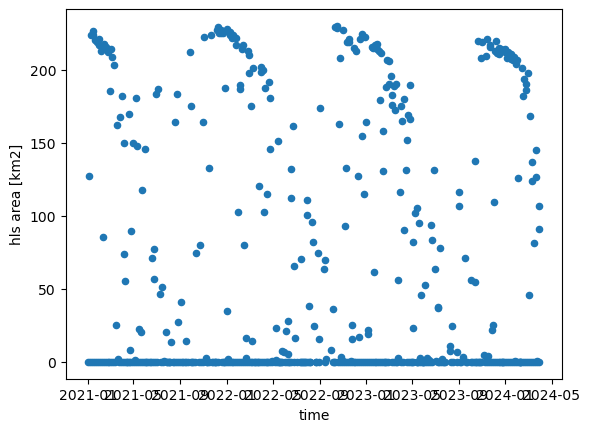

In [24]:
from rasterio.crs import CRS



def get_hls_area(
        ds, 
        reservoir_id, 
        buffer=0.05,
        save_dir=None
    ):
    res_id = reservoir_id

    res_poly = val_res_poly[val_res_poly['tmsos_id']==res_id]
    res_poly_buffered = res_poly.copy()
    
    res_poly_buffered['geometry'] = res_poly.buffer(buffer).to_crs(ds.rio.crs.to_string())
    ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    ds_crs = CRS.from_wkt(ds.spatial_ref.attrs['crs_wkt'])
    ds.rio.write_crs(ds_crs, inplace=True)

    ds = ds.rio.clip(res_poly_buffered.geometry.values)

    water_map_ds = classify_hls(ds)

    df = water_map_ds['surface_water_area'].to_dataframe().rename(
        {"surface_water_area": "hls area [km2]"}, axis=1
    ).reset_index().drop(['spatial_ref', 'eo:cloud_cover_avg'], axis=1)

    if save_dir is not None:
        save_dir = Path('../data/area/hls')
        save_dir.mkdir(exist_ok=True)

        save_fp = save_dir / f'{res_id}.csv'

        df.to_csv(save_fp, index=False)

    return (df, water_map_ds)

def classify_hls(ds):
    # add surface water map
    water_map = (ds['ndwi'] > 0).rename('surface_water')
    water_map = water_map.dropna(dim='time')
    water_map.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    water_map.rio.write_crs(CRS.from_wkt(ds.spatial_ref.attrs['crs_wkt']), inplace=True)
    water_map.attrs['standard_name'] = "surface_water"
    water_map.attrs['long_name'] = "Surface water of lake/reservoir"
    
    # add area time series as a variable
    water_map_area = (water_map.sum(dim=['x', 'y']) * 30*30 * 1e-6).rename('surface_water_area') # km2
    water_map_area.attrs['standard_name'] = 'surface_water_area'
    water_map.attrs['long_name'] = "Surface water area of lake/reservoir"
    water_map_area.attrs['unit'] = 'km2'

    return xr.merge([water_map, water_map_area])

    
df, ds = get_hls_area(
    dsses[1],
    selected_reservoirs[1],
    buffer=0.05
)
df.plot.scatter(x='time', y='hls area [km2]')

In [25]:
ds['surface_water'].hvplot.image(
    x='x', y='y', groupby='time', geo=True
) + ds['surface_water_area'].hvplot(x='time', y='surface_water_area', kind='scatter')

BokehModel(combine_events=True, render_bundle={'docs_json': {'24cef2af-068d-476a-aa1b-ca4d2de4e43d': {'version…

In [4]:
from shapely.geometry import mapping
from holoviews.streams import Selection1D


def get_hls_area(ds, reservoir_id, val_res_poly, save_dir=None):
    res_id = reservoir_id

    res_poly = val_res_poly[val_res_poly['tmsos_id']==ds.reservoir.values]

    val_buffered_polys = res_poly.copy()
    area = val_buffered_polys['AREA_SKM_right'].loc[val_buffered_polys['tmsos_id'] == reservoir_id]
    buffer_area = area.values[0] * 0.00075
    val_buffered_polys['geometry'] = val_buffered_polys['geometry'].buffer(buffer_area)

    # water_map = ds['ndwi'] > -0.3

    # water_map = water_map.dropna(dim='time')

    # water_map.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    # water_map.rio.write_crs(f"epsg:{water_map.spatial_ref.values}", inplace=True)

    # water_map_area = water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6
    
    # # clipped = water_map.rio.clip(res_poly.geometry.apply(mapping), res_poly.crs, drop=True)

    return val_buffered_polys

get_hls_area(ds, '0505', val_res_poly)

/tmp/ipykernel_239336/3488060218.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  val_buffered_polys['geometry'] = val_buffered_polys['geometry'].buffer(buffer_area)


,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((91.86790 23.41564, 91.86638 23.41573..."


In [5]:
val_buffered_polys = val_res_poly.copy()
print(val_buffered_polys['AREA_SKM_right'])

water_map = (ds['ndwi'] > 0).rename('water')

ds['ndwi'].hvplot(
    x='x', y='y', groupby='time', geo=True, clim=(-1, 0.3), cmap='RdYlBu'
) * water_map.hvplot(
    x='x', y='y', groupby='time', geo=True, alpha=0.3, color='blue'
).opts(
    xlabel='Longitude', ylabel='Latitude', title=f'Dumboor - Harmonized Landsat Sentinel-2 NDWI'
) * val_buffered_polys.loc[val_buffered_polys['tmsos_id'] == reservoir_id].hvplot(geo=True, color='black', alpha=0.2)

47    287.81
60     91.94
82     34.41
92     38.42
Name: AREA_SKM_right, dtype: float64


BokehModel(combine_events=True, render_bundle={'docs_json': {'ee19ff5a-af01-43bb-8231-0783dae5a2f0': {'version…